In [1]:
import os
import nibabel as nb
import numpy as np
import matplotlib.pyplot as pl
import scipy as sp
from scipy.signal import savgol_filter
import matplotlib.colors as colors

%matplotlib inline

n_pars = 9
pos_startpos = 0
neg_startpos = n_pars

base_dir = '/Users/knapen/disks/ae_S/2018/visual/HCP7TFIXED' # '/home/shared/2018/visual/HCP7TFIXED'
subject = '999999'
subject_dir = os.path.join(base_dir, subject)

angle_index = 2
ecc_index = 3
rsq_index = 8
size_index = 4

In [2]:
# create angle representation
def add_angles(data, rsq_thresh=0.1, sub_thresh_value=-10):
    angles = np.angle(data[0,:] + 1j * data[1,:])
    angles[data[-1,:]<rsq_thresh] = sub_thresh_value
    return angles

def load_data(hemi, rsq_thresh=-0.1, fp_template='/Users/knapen/Downloads/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_{hemi}.func_bla_psc_av_ridge_est.gii'):
    gii_filename = fp_template.format(hemi=hemi)
    gii_in = nb.load(gii_filename)
    data = np.array([gii_in.darrays[i].data for i in range(len(gii_in.darrays))])
    
    # separate pos and neg
    pos_data = data[pos_startpos:pos_startpos+n_pars,:]
    neg_data = data[neg_startpos:neg_startpos+n_pars,:]
    
    # only necessary for older fits
#     pos_data = np.vstack((pos_data, add_angles(pos_data, rsq_thresh=rsq_thresh)))
#     neg_data = np.vstack((neg_data, add_angles(neg_data, rsq_thresh=rsq_thresh)))
    
    return pos_data, neg_data

def load_mask(hemi,mask_name='39_B05', fp_template='/Users/knapen/Downloads/cifti-2_test_data/Conte69.parcellations_VGD11b.32k_fs_LR.{mask_name}.dlabel.{hemi}.gii'):
    mask_filename = fp_template.format(hemi=hemi,mask_name=mask_name)
    mask_gii = nb.load(mask_filename)
    mask = mask_gii.darrays[1].data.astype(bool)
    
    return mask

In [3]:
pnd = [load_data(hemi, fp_template=os.path.join(subject_dir, 'tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_{hemi}.func_bla_psc_av_ridge_est.gii')) for hemi in ['L','R']]
ang_ms = [load_mask(hemi, mask_name='39_B05', fp_template=os.path.join(base_dir,'Conte69.parcellations_VGD11b.32k_fs_LR.{mask_name}.dlabel.{hemi}.gii')) for hemi in ['L','R']]
V1_nms = [load_mask(hemi, mask_name='17_B05', fp_template=os.path.join(base_dir,'Conte69.parcellations_VGD11b.32k_fs_LR.{mask_name}.dlabel.{hemi}.gii')) for hemi in ['L','R']]

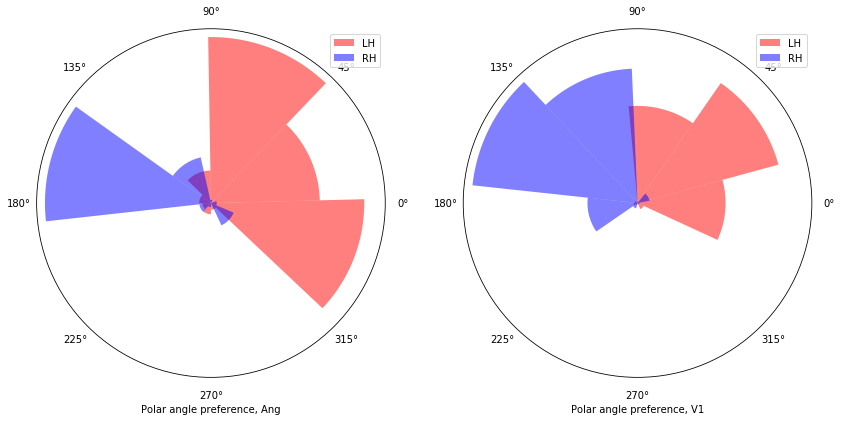

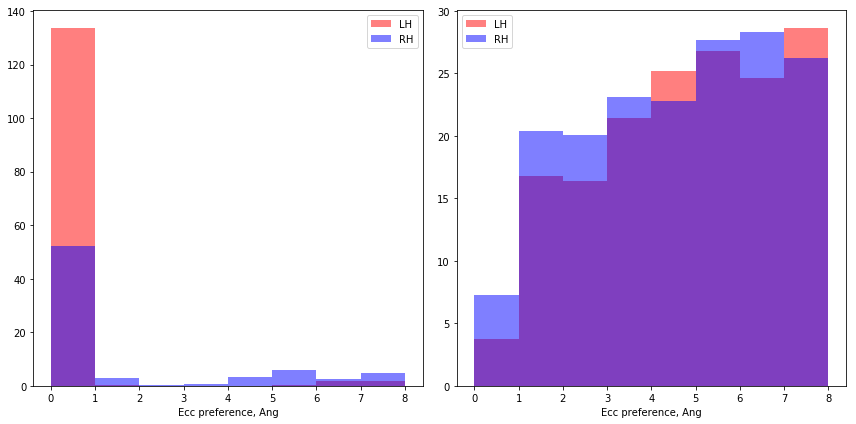

In [4]:
f = pl.figure(figsize = [12,6])
ax = f.add_subplot(121, projection='polar')
pl.hist(np.fmod(pnd[0][1][angle_index,ang_ms[0]]+np.pi/2, 2 * np.pi), weights=pnd[0][1][rsq_index,ang_ms[0]], color='r', alpha=0.5, label='LH', bins=8);
pl.hist(np.fmod(pnd[1][1][angle_index,ang_ms[1]]+np.pi/2, 2 * np.pi), weights=pnd[1][1][rsq_index,ang_ms[1]], color='b', alpha=0.5, label='RH', bins=8);
ax.grid(False)
ax.set_yticks([])
ax.set_xlabel('Polar angle preference, Ang')
pl.legend()
pl.tight_layout()
# f = pl.figure(figsize = [6,6])
ax = f.add_subplot(122, projection='polar')
pl.hist(np.fmod(pnd[0][0][angle_index,V1_nms[0]]+np.pi/2, 2 * np.pi), weights=pnd[0][0][rsq_index,V1_nms[0]], color='r', alpha=0.5, label='LH', bins=8);
pl.hist(np.fmod(pnd[1][0][angle_index,V1_nms[1]]+np.pi/2, 2 * np.pi), weights=pnd[1][0][rsq_index,V1_nms[1]], color='b', alpha=0.5, label='RH', bins=8);
ax.grid(False)
ax.set_yticks([])
ax.set_xlabel('Polar angle preference, V1')
pl.legend()
pl.tight_layout()

f = pl.figure(figsize = [12,6])
ax = f.add_subplot(121)
pl.hist(pnd[0][1][ecc_index,ang_ms[0]], weights=pnd[0][1][rsq_index,ang_ms[0]], color='r', alpha=0.5, label='LH', bins=np.arange(0,9));
pl.hist(pnd[1][1][ecc_index,ang_ms[1]], weights=pnd[1][1][rsq_index,ang_ms[1]], color='b', alpha=0.5, label='RH', bins=np.arange(0,9));
ax.grid(False)
# ax.set_yticks([])
ax.set_xlabel('Ecc preference, Ang')
pl.legend()
pl.tight_layout()
# f = pl.figure(figsize = [6,6])
ax = f.add_subplot(122)
pl.hist(pnd[0][0][ecc_index,V1_nms[0]], weights=pnd[0][0][rsq_index,V1_nms[0]], color='r', alpha=0.5, label='LH', bins=np.arange(0,9));
pl.hist(pnd[1][0][ecc_index,V1_nms[1]], weights=pnd[1][0][rsq_index,V1_nms[1]], color='b', alpha=0.5, label='RH', bins=np.arange(0,9));
ax.grid(False)
# ax.set_yticks([])
ax.set_xlabel('Ecc preference, Ang')
pl.legend()
pl.tight_layout()

In [5]:
def create_label_colors(precision, values, rsq, offset=0.08, out_txt_file='', out_gii_file='', gii_example=''):

    values_discrete = np.floor(values * precision).astype(np.int)
    rsq_discrete = np.floor(rsq * precision).astype(np.int)
    
    labels = np.array(['%03i_%03i'%(a,r) for a, r in zip(values_discrete, rsq_discrete)])
    coded_values = values_discrete + rsq_discrete * precision #ensures unique combinations
    
    hsv = np.zeros(list(values.shape) + [3])
    hsv[..., 0] = values_discrete / precision
    hsv[..., 1] = rsq_discrete / precision
    hsv[..., 2] = rsq_discrete / precision
    rgb = (np.nan_to_num(colors.hsv_to_rgb(hsv)) * 254).astype(np.uint8) + 1
    
    uniqs = np.unique(coded_values, axis=0, return_index=True)[1]
    line = """label_%s
%i %i %i %i 255
"""
    output = ''
    for u in uniqs:
        this_line = line%(labels[u], coded_values[u], rgb[u,0], rgb[u,1], rgb[u,2])
        output += this_line
    
    with open(out_txt_file, 'w') as f:
        f.write(output)
    
    # filename and such
    gii_in = nb.load(gii_example)
    gii_out = nb.gifti.gifti.GiftiImage(header=gii_in.header, 
                        extra=gii_in.extra,
                        darrays=[nb.gifti.gifti.GiftiDataArray(coded_values.astype(np.float32))])

    nb.save(gii_out, out_gii_file)    
    

In [6]:
for ih, hemi in enumerate(['L', 'R']):
    for i, side in enumerate(['pos', 'neg']):
        # filename and such
        gii_fn = os.path.join(subject_dir,'tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_{hemi}.func_bla_psc_av_est.gii'.format(hemi=hemi))
        # polar angle
        angs_n = np.fmod((pnd[ih][i][angle_index,:] + np.pi), 2 * np.pi) / (np.pi * 2.0)
        create_label_colors(precision=999,
                            values=angs_n, 
                            rsq=pnd[ih][i][rsq_index,:], 
                            offset=0.0, 
                            out_txt_file=os.path.join(subject_dir,'{hemi}_{side}_polar_ridge.metriclabel.txt'.format(hemi=hemi, side=side)), 
                            out_gii_file=os.path.join(subject_dir,'{hemi}_{side}_polar_ridge.metric.gii'.format(hemi=hemi, side=side)), 
                            gii_example=gii_fn)
        # ecc
        ecc_n = np.sqrt(pnd[ih][i][ecc_index,:]/16)
        ecc_n[ecc_n >= 1] = 1
        create_label_colors(precision=999,
                            values=ecc_n, 
                            rsq=pnd[ih][i][rsq_index,:], 
                            offset=0.0, 
                            out_txt_file=os.path.join(subject_dir,'{hemi}_{side}_ecc_ridge.metriclabel.txt'.format(hemi=hemi, side=side)), 
                            out_gii_file=os.path.join(subject_dir,'{hemi}_{side}_ecc_ridge.metric.gii'.format(hemi=hemi, side=side)),  
                            gii_example=gii_fn)

In [7]:
def convert_prf_data(gii_fn, hemi, subject_dir='', rsq_thresh=0):
    # load data
    gii_in = nb.load(gii_fn)
    prf_mean = np.array([gii_in.darrays[i].data for i in range(len(gii_in.darrays))])
    
    # rsq and sign
    rsq = np.nan_to_num(prf_mean[-1])
    if rsq_thresh != 0:
        rsq = (rsq > rsq_thresh).astype(bool)
    prf_sign = np.sign(np.nan_to_num(prf_mean[4]))
       
    # polar angle
    complex_peak_polar = prf_mean[0] + 1j * prf_mean[1]
    polar = np.fmod((np.angle(complex_peak_polar) + np.pi), 2 * np.pi) / (np.pi * 2.0)

    # eccentricity
    ecc = np.nan_to_num(
        np.sqrt(prf_mean[0]**2 + prf_mean[1]**2))
    ecc /= np.max(ecc)
    
    # size
    size = prf_mean[2].astype(np.float64)
    size /= np.max(size)
    
    # masks
    for name, var in zip(['ecc', 'size', 'polar', 'rsq'],[ecc, size, polar, rsq]):
        for side in ['neg', 'pos', 'all']:
            this_rsq = np.copy(rsq)
            if side == 'neg':
                this_rsq[prf_sign>0] = 0
            elif side == 'pos':
                this_rsq[prf_sign<0] = 0
                
            create_label_colors(precision=999,
                                values=var, 
                                rsq=this_rsq, 
                                offset=0.0, 
                                out_txt_file=os.path.join(subject_dir,
                                        '{hemi}_{side}_{name}.metriclabel.txt'.format(hemi=hemi, name=name, side=side)), 
                                out_gii_file=os.path.join(subject_dir,
                                        '{hemi}_{side}_{name}.metric.gii'.format(hemi=hemi, name=name, side=side)), 
                                gii_example=gii_fn)    


rh_gii_fn = os.path.join(subject_dir,'tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_R.func_bla_psc_av_est.gii')           
lh_gii_fn = os.path.join(subject_dir,'tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_L.func_bla_psc_av_est.gii')           


convert_prf_data(gii_fn=rh_gii_fn, hemi='R', subject_dir=subject_dir, rsq_thresh=0.0)
convert_prf_data(gii_fn=lh_gii_fn, hemi='L', subject_dir=subject_dir, rsq_thresh=0.0)


In [ ]:
os.system("""
# to convert metric output files to labels, using .txt label definition file
for hemi in R L
do
    for t in pos neg all
    do
        for pe in polar ecc size rsq
        do
            /Applications/workbench/bin_macosx64/wb_command \
            -metric-label-import ---SJ_DIR---/${hemi}_${t}_${pe}.metric.gii \
            ---SJ_DIR---/${hemi}_${t}_${pe}.metriclabel.txt \
            ---SJ_DIR---/${hemi}_${t}_${pe}.label.gii -unlabeled-value -1 &
            /Applications/workbench/bin_macosx64/wb_command \
            -metric-label-import ---SJ_DIR---/${hemi}_${t}_${pe}.metric.gii \
            ---SJ_DIR---/${hemi}_${t}_${pe}_ridge.metriclabel.txt \
            ---SJ_DIR---/${hemi}_${t}_${pe}_ridge.label.gii -unlabeled-value -1
            done
    done
done
""".replace("---SJ_DIR---",subject_dir))

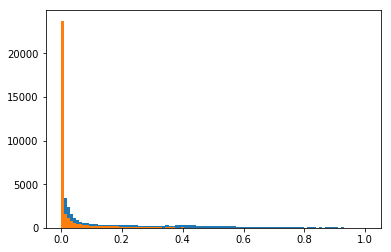

In [53]:
this_rsq = np.copy(rsq)
this_rsq[prf_sign>0] = 0

pl.hist(rsq, bins=np.linspace(0,1,100));
pl.hist(this_rsq, bins=np.linspace(0,1,100));

In [54]:
prf_sign.shape

(32492,)

In [8]:
np.average([0.03, -0.02, 0.20, 0.20, 0.16, 0.31])

0.1466666666666667

In [9]:
np.average([0.07, 0.1, 0.10, 0.12, 0.08, 0.10])

0.095000000000000015